# Simulation : Analyse de la stabilité temporelle de la segmentation retenue

In [62]:
# Nous allons étudier la stabilité temporelle de la segmentation clients retenue dans le but d'établir un
# contrat de maintenance.
# Nous allons pour cela repartir du dataframe des commandes clients.

Ce notebook sera dédié au contrat de maintenance. L'objectif est de faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance. Il s'agit de préciser une période de maintenance au bout de la quelle, l'algorithme doit être ré-étudié vu qu'il commence à perdre ses performances suite aux changements du jeu de données d'entrée.


-Pour prendre un exemple, supposons que l’entraînement du modèle initial M0 ait été réalisé à T0 pour un fichier clients F0, qui donne la liste des numéros de clusters C0, CO=M0.fit(F0).

-À T1=T0 +n semaines, un nouveau modèle M1 est entraîné sur le nouveau fichier clients F1 à T1, et donne une nouvelle liste de clusters C1, C1_new = M1.fit(F1).

-Si on utilise le modèle initial M0, à T1 la prédiction des numéros de clusters du fichier F1 des clients à T1 donne C1_init = M0.predict(F1).

-Il s’agit de comparer les clusters à T1 du fichier F1, selon que l’on utilise le modèle initial créé à T0(M0) via un « predict », ou le modèle créé à T1 via un « fit ».

Il est possible d’évaluer la cohérence entre les clusters de départ et le partitionnement trouvé par K-means en utilisant l’indice Ajusted_Rand_Score


Nous commencerons notre simulation avec les données existantes à t=52 semaines avant la dernière comande ,nous recommencerons les simulations en ajoutant 1 semaine supplementaire, et ainsi de suite. Nous comparerons les numéros de clusters à T1 du fichier F1, selon que l’on utilise le modèle initial créé à T0(M0) via un « predict », ou le modèle créé à T1 via un « fit ».

La standardisation pour le modèle M0 ne sera pas la même que pour le modèle Mi, donc quand on prédit avec M0 sur les données à T1, on utilise bien le standard scaler du modèle M0, et si on prédit avec M1, on utilise le standar scaler 
du modèle M1

Les étapes de cette démarche consistent en:

Le chargement du jeu de données nettoyé sur les commandes.
La selection de données afin de considérer que les données entre une date d'entrée et une date de sortie.
La standardisation des variables numériques: c'est une étape qui va se répéter à chaque itération.
Le score ARI est calculé entre les valeurs prédites avec le modèle M0 (année 1) et les valeurs considérées réelles prédites à patir d'un nouveau modèle Mi.

# Importation

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import pi
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics.cluster import adjusted_rand_score

from datetime import datetime
import matplotlib.dates as mdates

# chargement des données

Dans cette partie, nous allons utiliser le fichier commande créé dans le notebook 1 (exploration de données). il s'agira dans un premier temps de créer un fichier comprenant les commandes sélectionnées en fonction d'une période donnée.

In [64]:
data_simulation = pd.read_csv('OLIST_data_commande0_clean.csv')

In [65]:
data_simulation = data_simulation.drop("Unnamed: 0", axis=1)

In [66]:
data_simulation

,order_id,montant_total,customer_id,customer_unique_id,order_purchase_timestamp,review_score,payment_sum_per_ord,payment_sequential
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,5.0,72.19,1.0
1,00018f77f2f0320c557190d7a144bdd3,259.83,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,4.0,259.83,1.0
2,000229ec398224ef6ca0657da4fc703e,216.87,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,5.0,216.87,1.0
3,00024acbcdf0a6daa1e931b038114c75,25.78,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,4.0,25.78,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,5.0,218.04,1.0
...,...,...,...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,343.40,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,2018-04-23 13:57:06,5.0,343.40,1.0
98662,fffcd46ef2263f404302a634eb57f7eb,386.53,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,2018-07-14 10:26:46,5.0,386.53,1.0
98663,fffce4705a9662cd70adb13d4a31832d,116.85,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,2017-10-23 17:07:56,5.0,116.85,1.0
98664,fffe18544ffabc95dfada21779c9644f,64.71,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,2017-08-14 23:02:59,5.0,64.71,1.0


# Création des variables pour la segmentation RFM

In [67]:
from datetime import datetime

# Conversion des chaînes de caractères en objets datetime
data_simulation['order_purchase_timestamp'] = pd.to_datetime(
    data_simulation['order_purchase_timestamp']
)
# Période de commande (dernier achat)
min_date = data_simulation['order_purchase_timestamp'].min().strftime(
    '%d/%m/%Y %H:%M')

max_date = data_simulation['order_purchase_timestamp'].max().strftime(
    '%d/%m/%Y %H:%M')
f"Période d'achat : du {min_date} au {max_date}"

"Période d'achat : du 04/09/2016 21:15 au 03/09/2018 09:06"

In [68]:
# La période de commande en semaines
orders_weeks = round(
    (data_simulation['order_purchase_timestamp'].max() -
     data_simulation['order_purchase_timestamp'].min()).days / 7
)

"La période d'achat est de", orders_weeks, "semaines"

("La période d'achat est de", 104, 'semaines')

In [69]:
import datetime as dt
date_ref = data_simulation['order_purchase_timestamp'].max() + \
    dt.timedelta(days=1)
s_dateref = date_ref.strftime('%d/%m/%Y %Hh%M')
f'Data de référence pour la récence : {s_dateref}'

'Data de référence pour la récence : 04/09/2018 09h06'

In [70]:
# Convertir s_dateref en objet datetime
s_dateref_dt = pd.to_datetime(s_dateref, format='%d/%m/%Y %Hh%M')

# Définir T0 comme étant 1 an avant la date de référence
T0 = s_dateref_dt - pd.DateOffset(years=1)

# Convertir 'max_date' en objet datetime
max_date = pd.to_datetime(max_date, format='%d/%m/%Y %H:%M')

# Définir Tfinal comme étant la date de la dernière comande
T_final = max_date

# Définir une fréquence de temps correspondant à une période de 7 jours
dt = '7D'

print("T0 (1 an avant la date de référence) : ", T0)
print("Date finale : ", T_final)
print("Fréquence de temps : ", dt)

T0 (1 an avant la date de référence) :  2017-09-04 09:06:00
Date finale :  2018-09-03 09:06:00
Fréquence de temps :  7D


In [71]:
# l'ensemble des périodes à étudier
dates = pd.date_range(T0, T_final, freq=dt)

In [72]:
dates

DatetimeIndex(['2017-09-04 09:06:00', '2017-09-11 09:06:00',
               '2017-09-18 09:06:00', '2017-09-25 09:06:00',
               '2017-10-02 09:06:00', '2017-10-09 09:06:00',
               '2017-10-16 09:06:00', '2017-10-23 09:06:00',
               '2017-10-30 09:06:00', '2017-11-06 09:06:00',
               '2017-11-13 09:06:00', '2017-11-20 09:06:00',
               '2017-11-27 09:06:00', '2017-12-04 09:06:00',
               '2017-12-11 09:06:00', '2017-12-18 09:06:00',
               '2017-12-25 09:06:00', '2018-01-01 09:06:00',
               '2018-01-08 09:06:00', '2018-01-15 09:06:00',
               '2018-01-22 09:06:00', '2018-01-29 09:06:00',
               '2018-02-05 09:06:00', '2018-02-12 09:06:00',
               '2018-02-19 09:06:00', '2018-02-26 09:06:00',
               '2018-03-05 09:06:00', '2018-03-12 09:06:00',
               '2018-03-19 09:06:00', '2018-03-26 09:06:00',
               '2018-04-02 09:06:00', '2018-04-09 09:06:00',
               '2018-04-

In [77]:
from datetime import timedelta
import pandas as pd

def transformer(df, dates):
    # Convertir la colonne 'order_purchase_timestamp' en type datetime
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    
    # Filtrer les données pour ne conserver que celles antérieures à la date spécifiée
    df_t = df.loc[df['order_purchase_timestamp'] <= dates].copy()
    
    # Calculer la date de référence en ajoutant un jour à la date maximale de 'order_purchase_timestamp'
    ref = df_t['order_purchase_timestamp'].max() + timedelta(days=1)
    
    # Convertir la date de référence en format spécifique
    ref = pd.to_datetime(ref.strftime('%d/%m/%Y %Hh%M'), format='%d/%m/%Y %Hh%M')
    
    # Calculer le nombre de jours depuis la commande pour chaque entrée
    df_t['DaysSinceOrder'] = df_t['order_purchase_timestamp'].apply(lambda x: (ref - x).days)
    
    # Agréger les données par 'customer_unique_id'
    aggs = {
        'DaysSinceOrder': lambda x: min(x),
        'order_id': 'count',
        'montant_total': 'sum'
    }
    rfm = df_t.groupby('customer_unique_id').agg(aggs)
    
    # Renommer les colonnes pour correspondre à la notation RFM
    rfm.rename(columns={
        'DaysSinceOrder': 'recency',
        'order_id': 'frequency',
        'montant_total': 'monetary'
    }, inplace=True)
    
    return rfm


In [80]:
import datetime

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.pipeline import make_pipeline

# Appliquer la fonction transformer sur "RFM_simulation" avec la date "T0"
F0 = transformer(data_simulation, T0)

# Créer le modèle K-means initial
M0 = KMeans(n_clusters=4, n_init=2, init="k-means++")

# Normaliser F0:
scaler_F0 = StandardScaler().fit(F0)
F0_scaled = scaler_F0.transform(F0)

# Application du M0 sur F0
M0.fit(F0_scaled)

KMeans(n_clusters=4, n_init=2)

In [81]:
scaler_F0

StandardScaler()

In [82]:
# Initialiser les listes pour les scores ARI et accuracy
ari_scores = []
accuracy_scores = []
# Boucle pour calculer les scores ARI et accuracy pour chaque date dans "dates"
for Ti in dates:
    Fi = transformer(data_simulation, Ti) 
    Mi =KMeans(n_clusters=4, n_init=2, init="k-means++")
    # Normaliser Fi:
    scaler_Fi=StandardScaler().fit(Fi)
    Fi_scaled = scaler_Fi.transform(Fi)
    # Application du Mi sur Fi
    Mi.fit(Fi_scaled)
    # Normaliser Fi avec scaler_F0 :
    Fi_scaler_F0 = scaler_F0.transform(Fi)
    ari_scores += [adjusted_rand_score(M0.predict(Fi_scaler_F0), Mi.labels_)]
    accuracy_scores += [accuracy_score(M0.predict(Fi_scaler_F0), Mi.labels_)]

In [83]:
ari_scores

[0.99949716633763,
 0.9707759741504575,
 0.9713048625161094,
 0.8955305446520385,
 0.8665510750130815,
 0.8357347253477498,
 0.8223354676027484,
 0.8094329895389992,
 0.7572267334579103,
 0.703234493393651,
 0.6589685238372504,
 0.6285091359158345,
 0.6602802833593224,
 0.6724134828309699,
 0.6621731850777257,
 0.6382465435967678,
 0.6108023280205802,
 0.586233618273995,
 0.5614821211750783,
 0.5563235955356224,
 0.5517134575154015,
 0.5371373452523339,
 0.5291332955797666,
 0.5135101930697469,
 0.4953285224793053,
 0.49092843360340893,
 0.4775544227401654,
 0.4593413482319794,
 0.3802852664248539,
 0.35205451516962655,
 0.3249204252833767,
 0.3110827470758213,
 0.3053118406772435,
 0.3076742624456457,
 0.29473402561186496,
 0.279200310497473,
 0.2618000425444047,
 0.25324481424676887,
 0.23441613909758588,
 0.21923331092957593,
 0.21162906490653022,
 0.19838085626011825,
 0.18535254807135887,
 0.1744127010902611,
 0.16356158054638595,
 0.15155379676085382,
 0.1474597547901225,
 0.1450

In [84]:
df_scores1 = pd.DataFrame({
    'DATE': dates,
    'PERIOD': [str(x) for x in range(len(dates))],
    'ARI': ari_scores
})


In [85]:
 df_scores1 = pd.DataFrame({'DATE' : [date.date() for date in dates],
                          'PERIOD' : [str(x) for x in range(len(dates))],
                          'ARI' : ari_scores
                         })

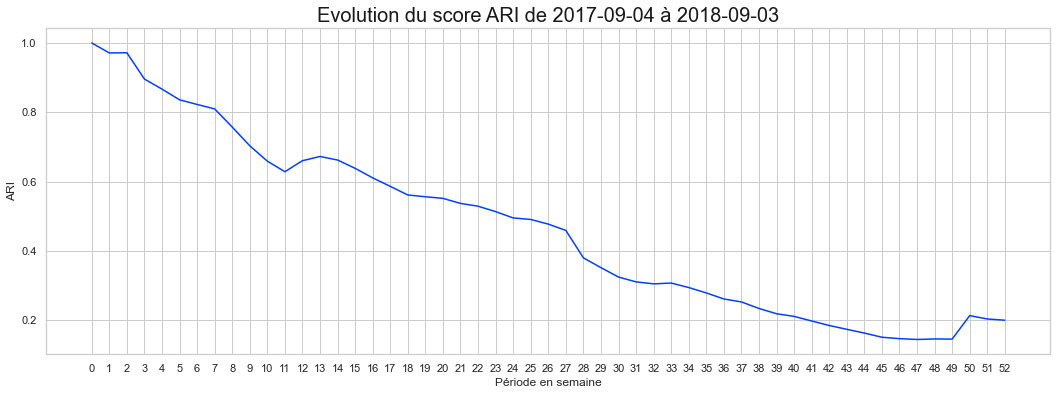

In [86]:
plt.figure(figsize=(18,6))
sns.set_theme(palette='bright', style='whitegrid')
sns.lineplot(data = df_scores1, x = 'PERIOD', y = 'ARI')
plt.xlabel('Période en semaine')
plt.title(f'Evolution du score ARI de {df_scores1.DATE[0]} à {df_scores1.DATE[df_scores1.shape[0]-1]}', c='k', fontsize=20)
plt.show()

Sur ce plot des scores ARI obtenus, on remarque une forte inflexion après 7 semaines sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation toutes les 7 semaines.